# Frequency and Surprisal

How sensitive are all the different layers to token frequency?

In [1]:
import sys
sys.path.append('../')

import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import seaborn as sns
import itertools
import math
import scipy

import src.anomaly_model

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load model

In [2]:
with open('../data/bnc.pkl', 'rb') as f:
  bnc_sentences = pickle.load(f)

random.seed(12345)
bnc_sentences = random.sample(bnc_sentences, 1000)

In [4]:
model = src.anomaly_model.AnomalyModel(bnc_sentences)

## Tabulate token frequencies

In [5]:
tokens, all_layer = model.gmm_score(bnc_sentences)

In [6]:
freq_counter = Counter(itertools.chain.from_iterable(tokens))

In [7]:
freq_counter.most_common(10)

[(' the', 617),
 ('�', 425),
 (' of', 365),
 (' to', 320),
 (' a', 298),
 (' and', 298),
 (' ', 220),
 (' in', 214),
 (' it', 204),
 (' that', 198)]

## Plot all layers

In [8]:
def plot_for_one_layer(layer):
  df = []
  for sent_ix, sent in enumerate(tokens[:100]):
    for tok_ix, token in enumerate(sent):
      surprisal = all_layer[sent_ix][layer, tok_ix]
      logfreq = math.log(freq_counter[token])
      df.append({'token': token, 'logfreq': logfreq, 'surprisal': surprisal})
  df = pd.DataFrame(df)
  corr = scipy.stats.pearsonr(df.logfreq, df.surprisal)[0]

  sns.regplot(x='logfreq', y='surprisal', data=df)
  plt.title(f'Layer {layer}, pearson={corr:0.2f}')
  plt.ylabel('Anomaly Score')
  plt.xlabel('Log Frequency')
  plt.show()

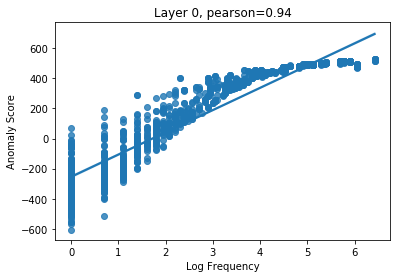

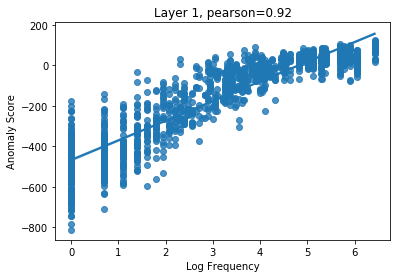

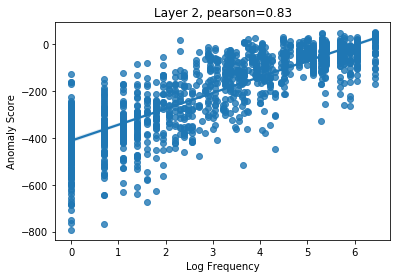

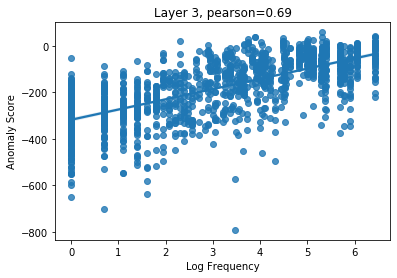

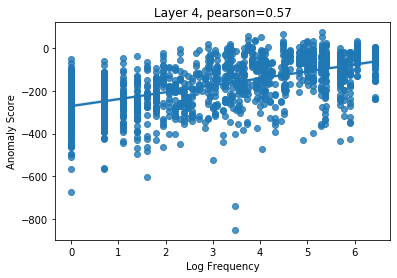

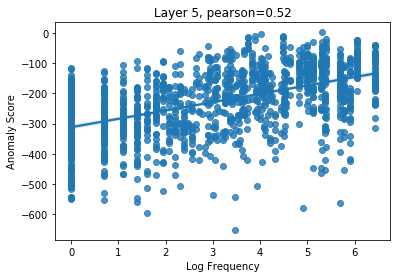

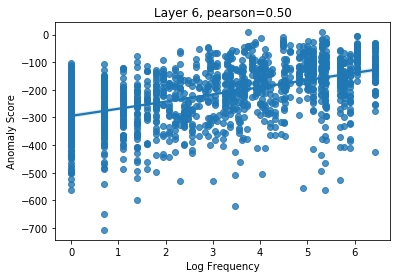

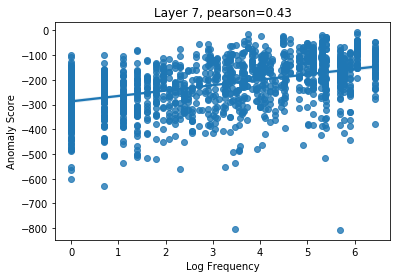

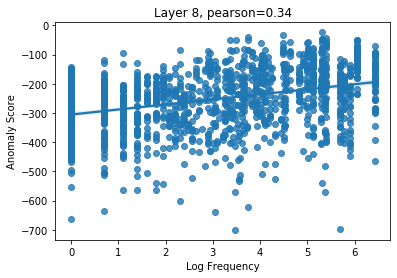

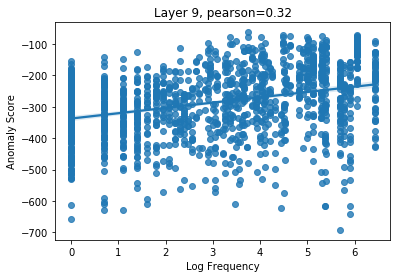

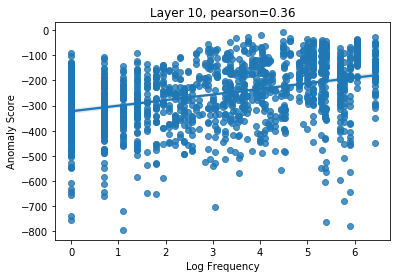

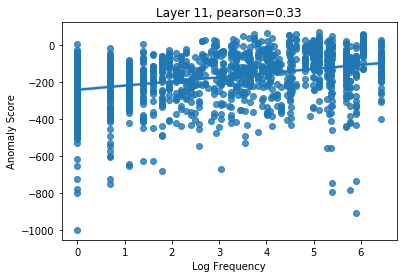

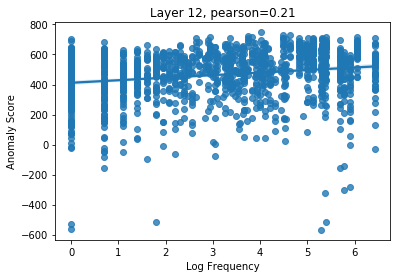

In [9]:
for layer in range(13):
  plot_for_one_layer(layer)